# CMPS 320 Final Project - Divorce Dataset Analysis

Our report aims to focus itself around the `Divorce Predictors` dataset. The dataset itself consists of data coming from 150 Turkish couples; 84 divorced, and 86 currently married, who completed an assessment aimed at getting a basic understanding of the couple, and their relationship. The data has 170 instances, containing 54 predictors in the form of a written question. These predictors are then divided into a 0-5 scale (inclusive). 

- Q1 - If one of us apologizes when our discussion deteriorates, the discussion ends.
- Q2 - I know we can ignore our differences, even if things get hard sometimes.
- Q3 - When we need it, we can take our discussions with my spouse from the beginning and correct it.
- Q4 - When I discuss with my spouse, to contact him will eventually work.
- Q5 - The time I spent with my spouse is special for us.
- Q6 - We don't have time at home as partners.
- Q7 - We are like two strangers who share the same environment at home rather than family.
- Q8 - I enjoy our holidays with my spouse.
- Q9 - I enjoy traveling with my spouse.
- Q10 - Most of our goals are common to my spouse.
- Q11 - I think that one day in the future, when I look back, I see that my spouse and I have been in harmony with each other.
- Q12 - My spouse and I have similar values in terms of personal freedom.
- Q13 - My spouse and I have similar sense of entertainment.
- Q14 - Most of our goals for people (children, friends, etc.) are the same.
- Q15 - Our dreams with my spouse are similar and harmonious.
- Q16 - We're compatible with my spouse about what love should be.
- Q17 - We share the same views about being happy in our life with my spouse
- Q18 - My spouse and I have similar ideas about how marriage should be
- Q19 - My spouse and I have similar ideas about how roles should be in marriage
- Q20 - My spouse and I have similar values in trust.
- Q21 - I know exactly what my spouse likes.
- Q22 - I know how my spouse wants to be taken care of when she/he sick.
- Q23 - I know my spouse's favorite food.
- Q24 - I can tell you what kind of stress my spouse is facing in her/his life.
- Q25 - I have knowledge of my spouse's inner world.
- Q26 - I know my spouse's basic anxieties.
- Q27 - I know what my spouse's current sources of stress are.
- Q28 - I know my spouse's hopes and wishes.
- Q29 - I know my spouse very well.
- Q30 - I know my spouse's friends and their social relationships.
- Q31 - I feel aggressive when I argue with my spouse.
- Q32 - When discussing with my spouse, I usually use expressions such as 'you always' or 'you never'.
- Q33 - I can use negative statements about my spouse's personality during our discussions.
- Q34 - I can use offensive expressions during our discussions.
- Q35 - I can insult my spouse during our discussions.
- Q36 - I can be humiliating when we discussions.
- Q37 - My discussion with my spouse is not calm.
- Q38 - I hate my spouse's way of open a subject.
- Q39 - Our discussions often occur suddenly.
- Q40 - We're just starting a discussion before I know what's going on.
- Q41 - When I talk to my spouse about something, my calm suddenly breaks.
- Q42 - When I argue with my spouse, I only go out and I don't say a word.
- Q43 - I mostly stay silent to calm the environment a little bit.
- Q44 - Sometimes I think it's good for me to leave home for a while.
- Q45 - I'd rather stay silent than discuss with my spouse.
- Q46 - Even if I'm right in the discussion, I stay silent to hurt my spouse.
- Q47 - When I discuss with my spouse, I stay silent because I am afraid of not being able to control my anger.
- Q48 - I feel right in our discussions.
- Q49 - I have nothing to do with what I've been accused of.
- Q50 - I'm not actually the one who's guilty about what I'm accused of.
- Q51 - I'm not the one who's wrong about problems at home.
- Q52 - I wouldn't hesitate to tell my spouse about her/his inadequacy.
- Q53 - When I discuss, I remind my spouse of her/his inadequacy.
- Q54 - I'm not afraid to tell my spouse about her/his incompetence.

## Importing packages

In [1]:
# imports
import warnings
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.formula.api as smf

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px


from sklearn import decomposition
from sklearn import preprocessing
from sklearn import metrics

%matplotlib inline
plt.style.use('seaborn-white')

warnings.filterwarnings('ignore')


## Loading, cleaning, and exploring dataset

In [2]:
divorces = pd.read_csv('divorce.csv', delimiter=';')
divorces = divorces.sample(frac=1, random_state=42) # we want a more randomized spread of our data

divorces.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q46,Q47,Q48,Q49,Q50,Q51,Q52,Q53,Q54,Divorce
139,3,1,1,0,0,0,0,0,0,0,...,3,2,2,0,2,2,0,0,4,0
30,3,4,3,2,3,0,1,4,3,2,...,4,4,4,4,4,4,4,4,4,1
119,0,1,1,0,0,2,0,0,0,0,...,2,2,2,0,2,1,1,1,0,0
29,4,3,3,2,4,1,0,3,3,2,...,4,4,4,4,4,4,4,4,4,1
144,0,0,2,4,0,0,0,0,0,2,...,2,0,2,4,0,0,1,0,0,0


In [3]:
divorces['Divorce'].value_counts() # roughly half of these couples are happily married, and (roughly) the other half of them are currently divorced

0    86
1    84
Name: Divorce, dtype: int64

In [4]:
divorces.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 139 to 102
Data columns (total 55 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Q1       170 non-null    int64
 1   Q2       170 non-null    int64
 2   Q3       170 non-null    int64
 3   Q4       170 non-null    int64
 4   Q5       170 non-null    int64
 5   Q6       170 non-null    int64
 6   Q7       170 non-null    int64
 7   Q8       170 non-null    int64
 8   Q9       170 non-null    int64
 9   Q10      170 non-null    int64
 10  Q11      170 non-null    int64
 11  Q12      170 non-null    int64
 12  Q13      170 non-null    int64
 13  Q14      170 non-null    int64
 14  Q15      170 non-null    int64
 15  Q16      170 non-null    int64
 16  Q17      170 non-null    int64
 17  Q18      170 non-null    int64
 18  Q19      170 non-null    int64
 19  Q20      170 non-null    int64
 20  Q21      170 non-null    int64
 21  Q22      170 non-null    int64
 22  Q23      170 non-null   

We can see here that we have no missing data, and everything that we are expecting to see is accounted for. With that, we can move forward.

In [5]:
y = divorces.Divorce
divorces = divorces.drop(['Divorce'], axis=1)
X = preprocessing.scale(divorces)

divorces['avg_score'] = divorces.mean(axis=1) # thought this was interesting to add, what can we do with this?
divorces.head() # now that we dropped our response variable, and added our new average score variable, we take another look


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q46,Q47,Q48,Q49,Q50,Q51,Q52,Q53,Q54,avg_score
139,3,1,1,0,0,0,0,0,0,0,...,3,2,2,0,2,2,0,0,4,0.611111
30,3,4,3,2,3,0,1,4,3,2,...,4,4,4,4,4,4,4,4,4,3.425926
119,0,1,1,0,0,2,0,0,0,0,...,2,2,2,0,2,1,1,1,0,0.555556
29,4,3,3,2,4,1,0,3,3,2,...,4,4,4,4,4,4,4,4,4,3.425926
144,0,0,2,4,0,0,0,0,0,2,...,2,0,2,4,0,0,1,0,0,0.629630


Text(0, 0.5, 'Average Score')

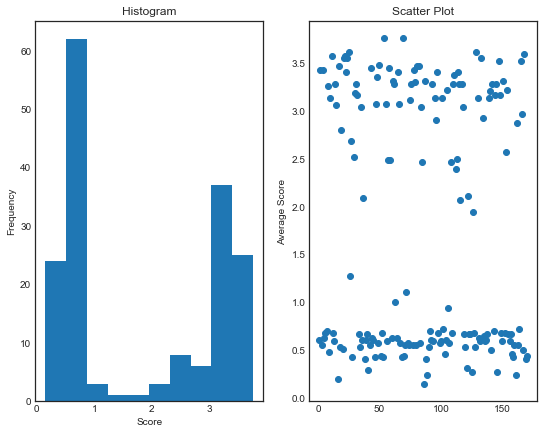

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 7))

ax1.hist(divorces.avg_score)
ax1.set_title('Histogram')
ax1.set_xlabel('Score')
ax1.set_ylabel('Frequency')

ax2.scatter([_ for _ in range(1,171)], divorces.avg_score)
ax2.set_title('Scatter Plot')
ax2.set_ylabel('Average Score')


By looking at this distribution, we can make an assumption that it is probably the low scores that are divorced; but we can't be sure. We will take a closer look at this to see if this is the case.

In [7]:
len(divorces.loc[divorces.avg_score <= 0.7])

81

In [8]:
len(divorces.loc[divorces.avg_score >= 2.5])


71